## Introduction - Détection de Sarcasme avec NLP

Ce notebook explore l'utilisation du **Natural Language Processing (NLP)** pour détecter le sarcasme dans les titres de presse.

**Problème** : Le sarcasme est une forme d'ironie difficile à détecter car elle nécessite de comprendre le contexte et les nuances linguistiques.

**Objectifs** :
- Découvrir les techniques de prétraitement NLP (tokenization, padding)
- Comprendre les embeddings de mots
- Comparer différentes architectures (Dense, LSTM, Bi-LSTM)
- Évaluer l'impact de la régularisation sur les performances

**Dataset** : Titres de presse annotés comme sarcastiques (1) ou non (0)

**Approches testées** :
1. Modèle simple sans embedding
2. Modèle avec embedding (baseline)
3. Modèle avec régularisation (Dropout + Early Stopping)
4. LSTM (mémoire séquentielle)
5. Bi-LSTM (contexte bidirectionnel)
6. Bi-LSTM ultra-régularisé

### Chargement Dataset

In [ ]:
!gdown --id 1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

import json
import pandas as pd
data=pd.read_json("./sarcasm.json")
data.head()

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v
To: /content/sarcasm.json
100% 5.64M/5.64M [00:00<00:00, 42.3MB/s]


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Téléchargement et chargement des données
Utilisation de `gdown` pour télécharger le dataset depuis Google Drive. Le fichier JSON contient des titres de presse avec leur label sarcasme/non-sarcasme.

# 1. Exploration des Données (EDA)

Nombre total d'observations : 26709

 Aperçu de la distribution des classes :
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


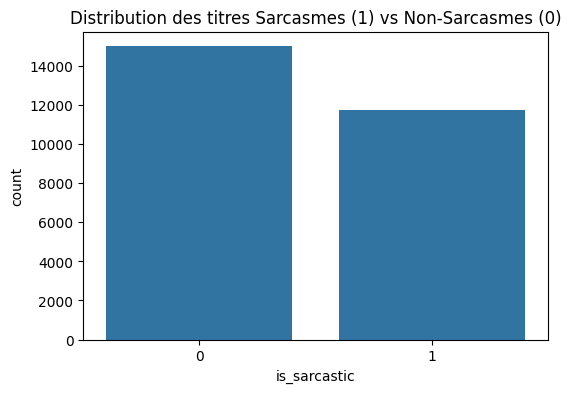


 Statistiques sur la longueur des titres (en mots) :
count    26709.000000
mean         9.845820
std          3.168955
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         39.000000
Name: headline_length, dtype: float64


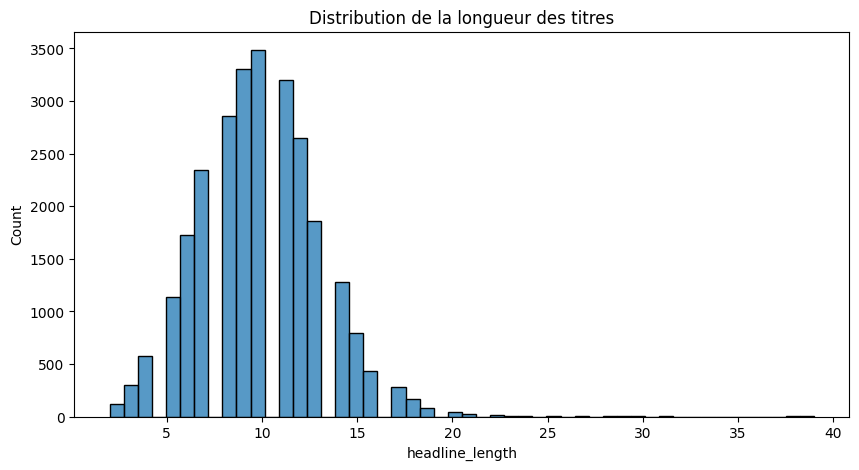

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Nombre total d'observations : {data.shape[0]}")
print("\n Aperçu de la distribution des classes :")
print(data['is_sarcastic'].value_counts())

# Création d'un graphique pour visualiser la distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_sarcastic', data=data)
plt.title('Distribution des titres Sarcasmes (1) vs Non-Sarcasmes (0)')
plt.show()

# Longueur des titres (nombre de mots)
data['headline_length'] = data['headline'].apply(lambda x: len(x.split()))
print("\n Statistiques sur la longueur des titres (en mots) :")
print(data['headline_length'].describe())

# Visualisation de la distribution des longueurs
plt.figure(figsize=(10, 5))
sns.histplot(data['headline_length'], bins=50)
plt.title('Distribution de la longueur des titres')
plt.show()

### Analyse exploratoire des données (EDA)

**Points clés à observer** :
- **Distribution des classes** : Est-elle équilibrée ? Un déséquilibre peut biaiser le modèle
- **Longueur des titres** : Aide à choisir `max_length` pour le padding
- **Statistiques descriptives** : Moyenne, médiane, écart-type des longueurs

L'EDA révèle les caractéristiques du dataset et guide les choix d'hyperparamètres.

# 2. Prétraitement du Texte

## Tokenization, Séquences et Padding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Extraction des caractéristiques (X) et des étiquettes (y)
sentences = data['headline'].tolist()
labels = data['is_sarcastic'].values

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

# --- Hyperparamètres ---
vocab_size = 10000
max_length = 100
oov_tok = "<OOV>"

# 1. Tokenization et Création de Séquences
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Entraînement du tokenizer uniquement sur les données d'entraînement
tokenizer.fit_on_texts(X_train)

# Affichage après Tokenization
word_index = tokenizer.word_index
print(f"Taille du vocabulaire total : {len(word_index)}")
print("\n--- Aperçu des 10 premiers tokens (mots et leur index) ---")
# On affiche les 10 premières paires mot:index
# Le tokenizer réserve l'index 0 pour le padding
# Le token OOV est généralement à l'index 1
for word, index in list(word_index.items())[:10]:
    print(f"'{word}': {index}")


# Convertir les textes en séquences d'entiers
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# --- Visualisation après la conversion en Séquences ---
sample_sentence = X_train[0]
sample_sequence = train_sequences[0]

print("\n--- Visualisation Séquences Numériques ---")
print(f"Phrase originale (X_train[0]) : {sample_sentence}")
print(f"Séquence numérique correspondante : {sample_sequence}")
print(f"Longueur de la séquence : {len(sample_sequence)}")


# 2. Padding (remplissage pour avoir la même longueur)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# --- Visualisation après Padding ---
sample_padded = train_padded[0]

print("\n--- Visualisation après Padding (maxlen=100) ---")
print(f"Séquence paddée : {sample_padded}")
print(f"Nouvelle longueur : {len(sample_padded)}")
print(f"Les '0' à la fin sont le padding, car padding='post'.")


print(f"\nTaille finale de l'ensemble d'entraînement après padding : {train_padded.shape}")
print(f"Taille finale de l'ensemble de test après padding : {test_padded.shape}")

Taille du vocabulaire total : 26536

--- Aperçu des 10 premiers tokens (mots et leur index) ---
'<OOV>': 1
'to': 2
'of': 3
'the': 4
'in': 5
'for': 6
'a': 7
'on': 8
'and': 9
'with': 10

--- Visualisation Séquences Numériques ---
Phrase originale (X_train[0]) : annoying ad turns man pro-whaling
Séquence numérique correspondante : [2378, 386, 731, 14, 905, 1]
Longueur de la séquence : 6

--- Visualisation après Padding (maxlen=100) ---
Séquence paddée : [2378  386  731   14  905    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Nouvelle longueur : 100
Les '0' à la

### Pipeline de prétraitement NLP

**1. Tokenization** : Convertit les mots en indices numériques
- Chaque mot unique reçoit un index
- `vocab_size=10000` : On garde les 10 000 mots les plus fréquents
- `oov_token="<OOV>"` : Token spécial pour les mots inconnus (Out Of Vocabulary)

**2. Conversion en séquences** : Remplace chaque phrase par une liste d'indices
```
"I love this" → [34, 156, 89]
```

**3. Padding** : Uniformise la longueur des séquences
- `maxlen=100` : Toutes les séquences auront 100 éléments
- `padding='post'` : Ajoute des 0 à la fin
- `truncating='post'` : Coupe les séquences trop longues à la fin

**Pourquoi ?** Les réseaux de neurones nécessitent des inputs de taille fixe.

# Modèle Séquentiel Simple (Sans Embedding)

Début de l'entraînement du Modèle Séquentiel Simple pour 10 époques...


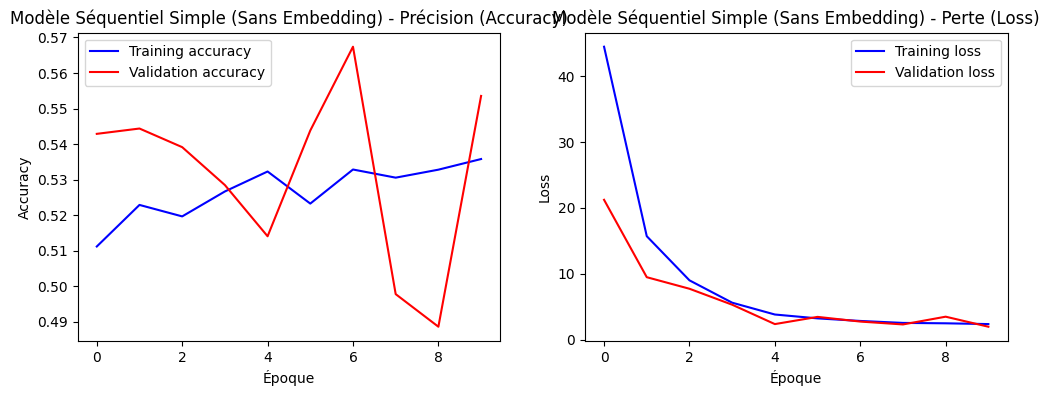


Évaluation finale du Modèle Séquentiel Simple sur l'ensemble de test:
Perte (Loss) : 1.9499
Précision (Accuracy) : 0.5535


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
import matplotlib.pyplot as plt

# --- Construction du Modèle ---
max_length = 100 # Rappel de l'hyperparamètre
model_simple = Sequential([
    Flatten(input_shape=(max_length,)),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_simple.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# --- Entraînement ---
num_epochs = 10
print(f"Début de l'entraînement du Modèle Séquentiel Simple pour {num_epochs} époques...")
history_simple = model_simple.fit(
    train_padded, y_train,
    epochs=num_epochs,
    validation_data=(test_padded, y_test),
    verbose=0 # On met verbose à 0 pour un affichage plus propre ensuite
)

# --- Visualisation des Résultats ---
def plot_history(history, title):
    """Fonction utilitaire pour tracer la perte et la précision."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Tracé de l'Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'{title} - Précision (Accuracy)')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()

    # Tracé de la Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Perte (Loss)')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Affichage des performances du modèle simple
plot_history(history_simple, 'Modèle Séquentiel Simple (Sans Embedding)')

# Évaluation finale
loss, accuracy = model_simple.evaluate(test_padded, y_test, verbose=0)
print(f"\nÉvaluation finale du Modèle Séquentiel Simple sur l'ensemble de test:")
print(f"Perte (Loss) : {loss:.4f}")
print(f"Précision (Accuracy) : {accuracy:.4f}")

### Modèle 1 : Architecture simple (Baseline naïve)

**Approche** : Traiter chaque séquence comme un vecteur plat de 100 entiers
- `Flatten` : Convertit (100,) en vecteur plat
- `Dense(24)` + `Dense(1)` : Classification classique

**Problèmes** :
- ❌ Pas de représentation sémantique des mots
- ❌ Les indices numériques n'ont aucune relation entre eux
- ❌ Aucune notion de proximité sémantique (ex: "bon" et "excellent")

**Résultat attendu** : Performance médiocre, mais établit une baseline rapide.

# Modèle avec Couche d'Embedding (Baseline)

Début de l'entraînement du Modèle avec Couche d'Embedding pour 30 époques...


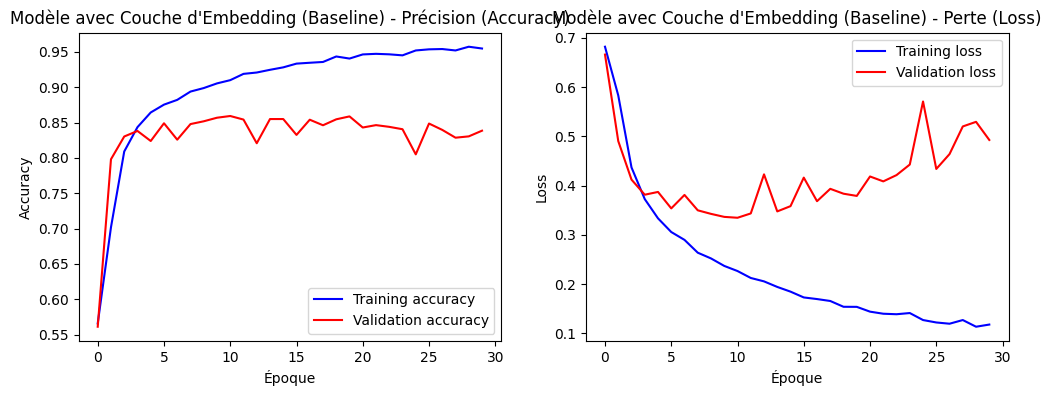


Évaluation finale du Modèle avec Couche d'Embedding sur l'ensemble de test:
Perte (Loss) : 0.4924
Précision (Accuracy) : 0.8385


In [ ]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D

# --- Construction du Modèle ---
vocab_size = 10000 # Rappel des hyperparamètres
embedding_dim = 16

model_embedding = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_embedding.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# --- Entraînement ---
num_epochs = 30 # Nous gardons 30 époques pour observer l'apprentissage de l'Embedding
print(f"Début de l'entraînement du Modèle avec Couche d'Embedding pour {num_epochs} époques...")
history_embedding = model_embedding.fit(
    train_padded, y_train,
    epochs=num_epochs,
    validation_data=(test_padded, y_test),
    verbose=0
)

# --- Visualisation des Résultats ---
# Réutilisation de la fonction plot_history définie précédemment
plot_history(history_embedding, 'Modèle avec Couche d\'Embedding (Baseline)')

# Évaluation finale
loss, accuracy = model_embedding.evaluate(test_padded, y_test, verbose=0)
print(f"\nÉvaluation finale du Modèle avec Couche d'Embedding sur l'ensemble de test:")
print(f"Perte (Loss) : {loss:.4f}")
print(f"Précision (Accuracy) : {accuracy:.4f}")

### Modèle 2 : Introduction de l'Embedding

**Couche Embedding** : Transforme chaque index en vecteur dense de dimension `embedding_dim`
- Chaque mot est représenté par un vecteur de 16 dimensions
- Ces vecteurs sont **appris** pendant l'entraînement
- Les mots similaires auront des embeddings proches dans l'espace vectoriel

**GlobalAveragePooling1D** : Agrège la séquence en calculant la moyenne
- Input : (100, 16) → Output : (16,)
- Perd l'ordre des mots mais capture le sens global

**Avantage** :
- ✅ Représentation sémantique des mots
- ✅ Bien meilleur que le modèle sans embedding

**Limitation** : Ignore l'ordre des mots (important pour le sarcasme !)

# Modèle avec Embedding et Régularisation (Eviter l'Overfiting)

Début de l'entraînement régularisé. EarlyStopping surveillera la validation loss...
Epoch 1/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5597 - loss: 0.6852 - val_accuracy: 0.5614 - val_loss: 0.6653
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6397 - loss: 0.6350 - val_accuracy: 0.8087 - val_loss: 0.4687
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8006 - loss: 0.4478 - val_accuracy: 0.8180 - val_loss: 0.4032
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8312 - loss: 0.3821 - val_accuracy: 0.7905 - val_loss: 0.4348
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8514 - loss: 0.3352 - val_accuracy: 0.8132 - val_loss: 0.4072
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8762 - loss: 0.2985 - val_accuracy: 0.8403 - val_loss: 0.3600
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8863 - loss: 0.2760 - val_accuracy: 0.8388 - val_loss: 0.3604
Epoch 8/50
668/668 ━

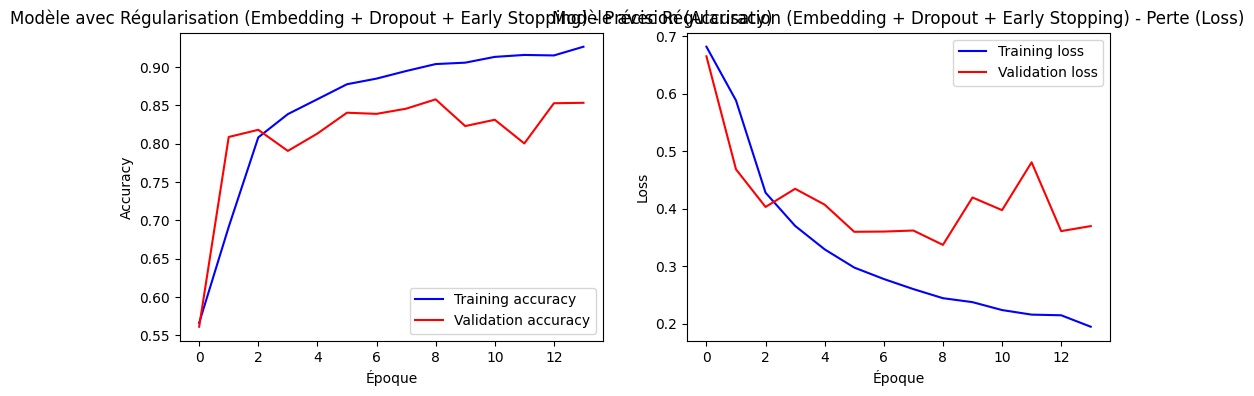


Évaluation finale du Modèle Régularisé sur l'ensemble de test:
Perte (Loss) : 0.3372
Précision (Accuracy) : 0.8577


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Hyperparamètres ---
vocab_size = 10000
max_length = 100
embedding_dim = 16

# --- 1. Construction du Modèle avec Dropout ---
# On ajoute deux couches Dropout avec un taux de 20% (0.2)
model_regularized = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),

    # Dropout 1: Appliqué après l'agrégation des embeddings
    Dropout(0.2),

    Dense(24, activation='relu'),

    # Dropout 2: Appliqué avant la couche de sortie
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

model_regularized.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# --- 2. Configuration de l'Early Stopping ---
# Arrête l'entraînement si 'val_loss' ne s'améliore pas après 5 époques (patience=5)
# restore_best_weights=True garantit que le modèle revient à l'état où la val_loss était la plus basse.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- 3. Entraînement ---
num_epochs = 50 # On met un nombre élevé, mais EarlyStopping va arrêter avant.
print(f"Début de l'entraînement régularisé. EarlyStopping surveillera la validation loss...")

history_regularized = model_regularized.fit(
    train_padded, y_train,
    epochs=num_epochs,
    validation_data=(test_padded, y_test),
    # Intégration du callback EarlyStopping ici
    callbacks=[early_stop],
    verbose=1
)

# --- 4. Visualisation des Résultats ---
def plot_history(history, title):
    """Fonction utilitaire pour tracer la perte et la précision."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'{title} - Précision (Accuracy)')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Perte (Loss)')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_regularized, 'Modèle avec Régularisation (Embedding + Dropout + Early Stopping)')

# --- 5. Évaluation finale ---
loss, accuracy = model_regularized.evaluate(test_padded, y_test, verbose=0)
print(f"\nÉvaluation finale du Modèle Régularisé sur l'ensemble de test:")
print(f"Perte (Loss) : {loss:.4f}")
print(f"Précision (Accuracy) : {accuracy:.4f}")

### Modèle 3 : Combat contre l'overfitting

**Techniques de régularisation** :

1. **Dropout(0.2)** : Désactive aléatoirement 20% des neurones pendant l'entraînement
   - Force le réseau à apprendre des représentations redondantes
   - Réduit la dépendance à des neurones spécifiques

2. **Early Stopping** : Arrête l'entraînement si `val_loss` ne s'améliore pas
   - `patience=5` : Attend 5 époques sans amélioration
   - `restore_best_weights` : Recharge les meilleurs poids

**Observation des courbes** :
- Training/Validation proches → Pas d'overfitting
- Validation stagne/augmente → Overfitting détecté

**Amélioration** : Généralisation sur données non vues.

# Implémentation du Modèle LSTM

## Le Rôle du LSTM
Le LSTM est un type de réseau de neurones récurrents (RNN) conçu pour gérer la dépendance et l'ordre dans les données séquentielles.

**Mémoire :** Les LSTM possèdent des "portes" (input, forget, output) qui leur permettent de sélectivement retenir (mémoire à long terme) ou oublier (mémoire à court terme) des informations passées dans la séquence.

**Contexte :** En lisant les mots de gauche à droite, un LSTM construit un état interne qui encode le contexte accumulé de la phrase jusqu'au mot actuel.

**Classification :** À la fin de la séquence, l'état final du LSTM (le dernier vecteur) résume l'intégralité de la phrase en tenant compte de la sémantique et de l'ordre, ce qui est beaucoup plus pertinent pour la classification.

## Architecture du Modèle LSTM
Le modèle LSTM va suivre la même structure que votre baseline, mais la couche GlobalAveragePooling1D sera remplacée par la couche LSTM.

**Couche d'Entrée (Input) :** Prend la séquence paddée d'index de mots (max_length=100).

**Couche d'Embedding :** Convertit les index en vecteurs sémantiques. (Forme : 100 x 16).

**Couche LSTM :** Traite la séquence de 100 vecteurs, un par un, en conservant l'ordre. Nous utiliserons des unités LSTM (par exemple 32). L'output de cette couche sera le dernier état de la cellule, résumant la phrase.

**Couches Denses & Dropout :** Couches de classification pour passer de la représentation LSTM finale (32 dimensions) à la prédiction binaire (0 ou 1).

Résumé du Modèle avec Couche LSTM:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Début de l'entraînement du Modèle LSTM. EarlyStopping surveillera la validation loss...
Epoch 1/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.5519 - loss: 0.6880 - val_accuracy: 0.5608 - val_loss: 0.6858
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.5639 - loss: 0.6854 - val_accuracy: 0.5608 - val_loss: 0.6858
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.5640 - loss: 0.6854 - val_accuracy: 0.5608 - val_loss: 0.6858
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.5640 - loss: 0.6851 - val_accuracy: 0.5608 - val_loss: 0.6862
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.5649 - loss: 0.6851 - val_accuracy: 0.5608 - val_loss: 0.6858
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.5574 - loss: 0.6867 - val_accuracy: 0.5608 - val_loss: 0.6859
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.5654 - loss: 0.6848 - val_accuracy: 0.5608 - val_loss: 0.6857
Ep

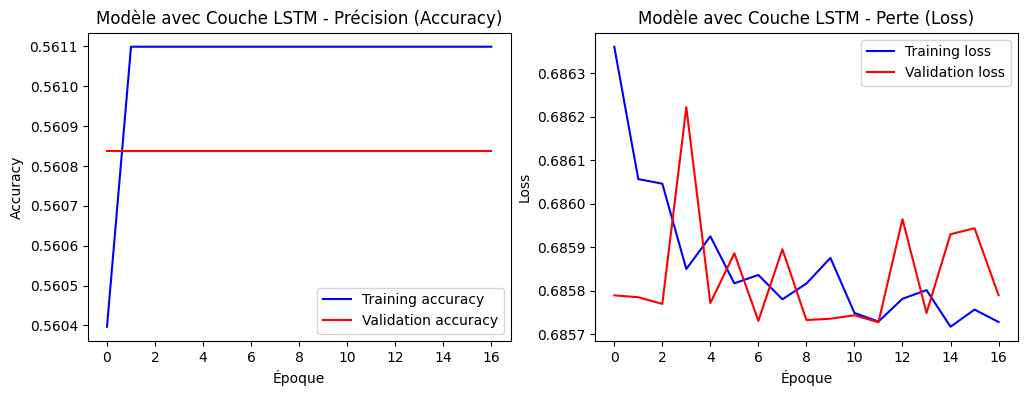


Évaluation finale du Modèle LSTM sur l'ensemble de test:
Perte (Loss) : 0.6857
Précision (Accuracy) : 0.5608


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Hyperparamètres ---
vocab_size = 10000
max_length = 100
embedding_dim = 16
# Nouveau hyperparamètre clé pour le LSTM
lstm_units = 32

# --- 1. Construction du Modèle LSTM ---
model_lstm = Sequential([
    # Couche d'Embedding (Input: 100 séquences, Output: 100 séquences de 16-dim vecteurs)
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Couche LSTM : Prend la séquence de l'Embedding.
    # La sortie par défaut (return_sequences=False) est le vecteur d'état final (32-dim)
    LSTM(lstm_units),

    # Dropout pour la régularisation (empêcher l'overfitting)
    Dropout(0.2),

    # Couche Dense cachée
    Dense(24, activation='relu'),

    # Couche de sortie
    Dense(1, activation='sigmoid')
])

# --- 2. Compilation ---
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Résumé du Modèle avec Couche LSTM:")
model_lstm.summary()

# --- 3. Early Stopping ---
# Moniteur 'val_loss', patience de 5 époques
early_stop_lstm = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- 4. Entraînement ---
num_epochs = 50
print(f"Début de l'entraînement du Modèle LSTM. EarlyStopping surveillera la validation loss...")

history_lstm = model_lstm.fit(
    train_padded, y_train,
    epochs=num_epochs,
    validation_data=(test_padded, y_test),
    callbacks=[early_stop_lstm],
    verbose=1
)

# --- 5. Visualisation des Résultats (Réutilisation de la fonction) ---
def plot_history(history, title):
    """Fonction utilitaire pour tracer la perte et la précision."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'{title} - Précision (Accuracy)')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Perte (Loss)')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_lstm, 'Modèle avec Couche LSTM')

# --- 6. Évaluation finale ---
loss, accuracy = model_lstm.evaluate(test_padded, y_test, verbose=0)
print(f"\nÉvaluation finale du Modèle LSTM sur l'ensemble de test:")
print(f"Perte (Loss) : {loss:.4f}")
print(f"Précision (Accuracy) : {accuracy:.4f}")

### Modèle 4 : LSTM - Comprendre l'ordre des mots

**Problème résolu** : GlobalAveragePooling ignore l'ordre → LSTM le préserve !

**Fonctionnement du LSTM** :
```
Mot 1 → LSTM → État 1
Mot 2 + État 1 → LSTM → État 2
...
Mot 100 + État 99 → LSTM → État final (résumé de toute la phrase)
```

**Mécanismes clés** :
- **Input Gate** : Décide quelles nouvelles infos garder
- **Forget Gate** : Décide quelles anciennes infos oublier
- **Output Gate** : Décide quoi transmettre à l'étape suivante

**Avantage** :
- ✅ Capture les dépendances à long terme
- ✅ Comprend le contexte séquentiel
- ✅ "I love waiting in traffic" → détecte l'ironie grâce à l'ordre

**Architecture** : Embedding → LSTM(32) → Dense → Output

# Implémentation du Bi-LSTM Optimisé
Le Bidirectional LSTM (Bi-LSTM) est la technique la plus efficace pour ce type de problème.

**Principe :** Il utilise deux LSTM séparés qui lisent la séquence :

- Un LSTM lit la séquence dans le sens normal (gauche $\rightarrow$ droite).

- Un autre LSTM lit la séquence dans le sens inverse (droite $\rightarrow$ gauche).

**Avantage :** L'état final combine le contexte passé et le contexte futur, ce qui est parfait pour capturer les nuances des phrases sarcastiques.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Hyperparamètres Optimisés ---
vocab_size = 10000
max_length = 100
# Augmentation de la dimension de l'embedding
embedding_dim = 100
# Augmentation des unités LSTM (chaque direction aura 64 unités)
lstm_units = 64

# --- 1. Construction du Modèle Bidirectionnel LSTM ---
model_bilstm = Sequential([
    # Couche d'Embedding optimisée
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Bidirectional(LSTM) : Encapsule le LSTM. Le résultat est la concaténation
    # de l'état final de la lecture avant et arrière (64 * 2 = 128 dimensions).
    Bidirectional(LSTM(lstm_units)),

    # Dropout pour la régularisation
    Dropout(0.3), # Un peu plus de dropout vu la complexité

    # Couche Dense cachée
    Dense(32, activation='relu'),

    # Couche de sortie
    Dense(1, activation='sigmoid')
])

# --- 2. Compilation et Early Stopping ---
model_bilstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Résumé du Modèle Bidirectionnel LSTM Optimisé:")
model_bilstm.summary()

# Early Stopping pour éviter l'overfitting, patience augmentée
early_stop_bilstm = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# --- 3. Entraînement ---
num_epochs = 50
print(f"Début de l'entraînement du Modèle Bi-LSTM...")

history_bilstm = model_bilstm.fit(
    train_padded, y_train,
    epochs=num_epochs,
    validation_data=(test_padded, y_test),
    callbacks=[early_stop_bilstm],
    verbose=1
)

# --- 4. Évaluation finale ---
# (La fonction plot_history est réutilisable)
# plot_history(history_bilstm, 'Modèle Bidirectionnel LSTM Optimisé')

loss, accuracy = model_bilstm.evaluate(test_padded, y_test, verbose=0)
print(f"\nÉvaluation finale du Modèle Bi-LSTM sur l'ensemble de test:")
print(f"Perte (Loss) : {loss:.4f}")
print(f"Précision (Accuracy) : {accuracy:.4f}")

Résumé du Modèle Bidirectionnel LSTM Optimisé:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Début de l'entraînement du Modèle Bi-LSTM...
Epoch 1/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 86s 120ms/step - accuracy: 0.7338 - loss: 0.4980 - val_accuracy: 0.8684 - val_loss: 0.3150
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - accuracy: 0.9257 - loss: 0.1931 - val_accuracy: 0.8682 - val_loss: 0.3241
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - accuracy: 0.9638 - loss: 0.1036 - val_accuracy: 0.8609 - val_loss: 0.3777
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 81s 118ms/step - accuracy: 0.9803 - loss: 0.0601 - val_accuracy: 0.8497 - val_loss: 0.4613
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 79s 118ms/step - accuracy: 0.9884 - loss: 0.0360 - val_accuracy: 0.8566 - val_loss: 0.5862
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 80s 120ms/step - accuracy: 0.9924 - loss: 0.0252 - val_accuracy: 0.8426 - val_loss: 0.7745
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 81s 118ms/step - accuracy: 0.9960 - loss: 0.0147 - val_accuracy: 0.8501 - val_loss: 0.8545
Epoch 8/50
668/668 ━━━━━━━━━━━━━━━━━━━

### Modèle 5 : Bi-LSTM - Le meilleur des deux mondes

**Innovation** : Lecture de la séquence dans les deux sens !

```
Forward LSTM:  "I" → "love" → "this" → [État avant]
Backward LSTM: "this" ← "love" ← "I" ← [État arrière]
Résultat: Concaténation des deux états → (64*2 = 128 dimensions)
```

**Pourquoi c'est puissant ?**
- ✅ Contexte passé + contexte futur
- ✅ Crucial pour le sarcasme : "This is *just* what I needed" (le "just" prend sens avec ce qui suit)
- ✅ Meilleure compréhension des nuances

**Optimisations** :
- `embedding_dim=100` (vs 16) : Représentations plus riches
- `lstm_units=64` (vs 32) : Plus de capacité mémoire
- `Dropout(0.3)` : Régularisation adaptée

# Entraînement et Tracé du Modèle Bi-LSTM

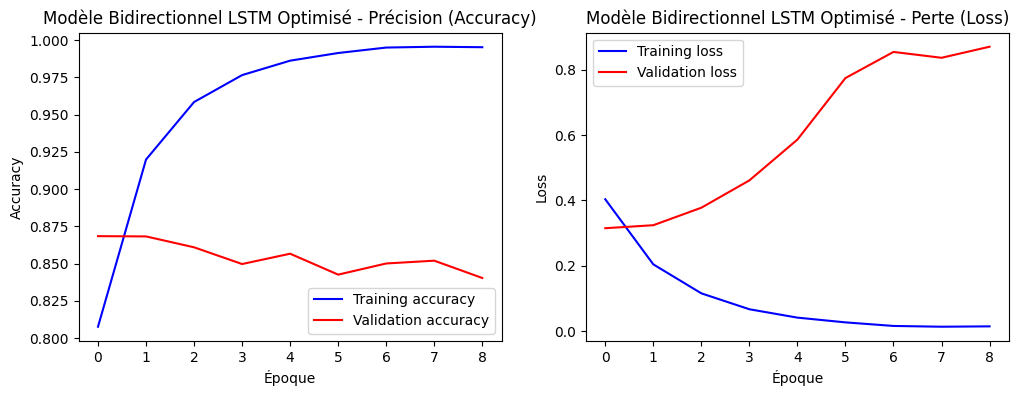


Évaluation finale du Modèle Bi-LSTM sur l'ensemble de test:
Perte (Loss) : 0.3150
Précision (Accuracy) : 0.8684


In [ ]:
# --- (Code de construction du modèle Bi-LSTM et Entraînement 'model_bilstm.fit()' ici) ---
# ... (Assuming history_bilstm is available from the training in the previous step) ...

# Fonction de tracé (si elle n'est pas déjà dans votre Notebook)
def plot_history(history, title):
    """Fonction utilitaire pour tracer la perte et la précision."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Tracé de l'Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'{title} - Précision (Accuracy)')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()

    # Tracé de la Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Perte (Loss)')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# --- 1. Exécution du Tracé ---
plot_history(history_bilstm, 'Modèle Bidirectionnel LSTM Optimisé')

# --- 2. Évaluation finale (répétée pour complétude) ---
loss, accuracy = model_bilstm.evaluate(test_padded, y_test, verbose=0)
print(f"\nÉvaluation finale du Modèle Bi-LSTM sur l'ensemble de test:")
print(f"Perte (Loss) : {loss:.4f}")
print(f"Précision (Accuracy) : {accuracy:.4f}")

### Visualisation et évaluation du Bi-LSTM

Cette section réutilise la fonction de plotting pour analyser :
- **Convergence** : Les courbes se stabilisent-elles ?
- **Gap Train/Val** : Y a-t-il overfitting ?
- **Accuracy finale** : Performance sur données de test

Le Bi-LSTM devrait montrer les **meilleures performances** grâce à sa compréhension bidirectionnelle.

# Modèle Bi-LSTM Ultra-Régularisé

Résumé du Modèle Bi-LSTM Ultra-Régularisé:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Début de l'entraînement du Modèle Ultra-Régularisé...
Epoch 1/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 87s 124ms/step - accuracy: 0.7390 - loss: 0.5059 - val_accuracy: 0.8617 - val_loss: 0.3340
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 81s 121ms/step - accuracy: 0.9276 - loss: 0.2060 - val_accuracy: 0.8620 - val_loss: 0.3466
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 80s 120ms/step - accuracy: 0.9621 - loss: 0.1212 - val_accuracy: 0.8574 - val_loss: 0.4170
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 81s 119ms/step - accuracy: 0.9770 - loss: 0.0772 - val_accuracy: 0.8538 - val_loss: 0.5161
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 80s 120ms/step - accuracy: 0.9849 - loss: 0.0557 - val_accuracy: 0.8478 - val_loss: 0.6021
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 79s 119ms/step - accuracy: 0.9918 - loss: 0.0368 - val_accuracy: 0.8450 - val_loss: 0.6589
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.9941 - loss: 0.0291 - val_accuracy: 0.8435 - val_loss: 0.6508
Epoch 8/50
668/668 ━━━━━━━━━━

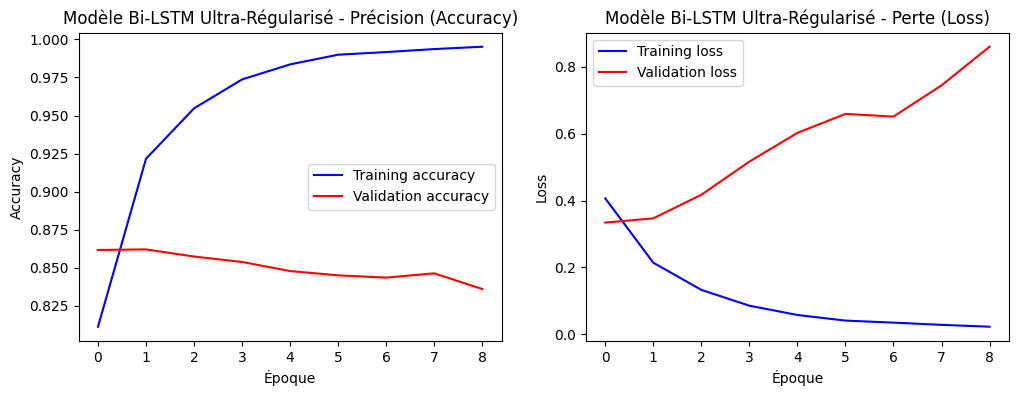


Évaluation finale du Modèle Bi-LSTM Ultra-Régularisé sur l'ensemble de test:
Perte (Loss) : 0.3340
Précision (Accuracy) : 0.8617


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers # Nouvelle importation
import matplotlib.pyplot as plt

# --- Hyperparamètres (Capacité conservée, Régularisation ajoutée) ---
vocab_size = 10000
max_length = 100
embedding_dim = 100 # Augmentée précédemment
lstm_units = 64     # Augmentée précédemment

# --- 1. Construction du Modèle avec Dropout et L2 ---
model_ultra_regularized = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # LSTM Bidirectionnel avec Régularisation L2
    Bidirectional(LSTM(
        lstm_units,
        # Pénalise les poids du LSTM
        kernel_regularizer=regularizers.l2(1e-4)
    )),

    # Augmentation du Dropout (50%)
    Dropout(0.5),

    # Couche Dense cachée avec Régularisation L2
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),

    # Couche de sortie
    Dense(1, activation='sigmoid')
])

# --- 2. Compilation et Early Stopping ---
model_ultra_regularized.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Résumé du Modèle Bi-LSTM Ultra-Régularisé:")
model_ultra_regularized.summary()

# Early Stopping pour éviter l'overfitting
early_stop_reg = EarlyStopping(
    monitor='val_loss',
    patience=8, # On laisse une bonne patience, mais il devrait s'arrêter plus tôt.
    restore_best_weights=True,
    verbose=1
)

# --- 3. Entraînement ---
num_epochs = 50
print(f"Début de l'entraînement du Modèle Ultra-Régularisé...")

history_ultra_regularized = model_ultra_regularized.fit(
    train_padded, y_train,
    epochs=num_epochs,
    validation_data=(test_padded, y_test),
    callbacks=[early_stop_reg],
    verbose=1
)

# --- 4. Tracé et Évaluation finale ---
def plot_history(history, title):
    """Fonction utilitaire pour tracer la perte et la précision."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'{title} - Précision (Accuracy)')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Perte (Loss)')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_ultra_regularized, 'Modèle Bi-LSTM Ultra-Régularisé')

loss, accuracy = model_ultra_regularized.evaluate(test_padded, y_test, verbose=0)
print(f"\nÉvaluation finale du Modèle Bi-LSTM Ultra-Régularisé sur l'ensemble de test:")
print(f"Perte (Loss) : {loss:.4f}")
print(f"Précision (Accuracy) : {accuracy:.4f}")

### Modèle 6 : Ultra-régularisation

**Diagnostic** : Si le Bi-LSTM overfit malgré le Dropout, on renforce la régularisation !

**Nouvelles techniques** :

1. **L2 Regularization** (`kernel_regularizer=l2(1e-4)`)
   - Pénalise les poids trop élevés dans la loss function
   - Force des poids plus petits et distribués
   - Loss totale = Loss classification + λ × Σ(poids²)

2. **Dropout augmenté** : 0.3 → 0.5
   - Désactive 50% des connexions
   - Régularisation très agressive

**Résultat attendu** :
- Training accuracy plus basse (effet de la régularisation)
- Validation accuracy stable ou meilleure
- Meilleure généralisation sur données réelles

# Bi-LSTM Ultra-Régularisé (V2)

Résumé du Modèle Bi-LSTM V2 (Capacité Réduite + Recurrent Dropout):


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Début de l'entraînement du Modèle V2...
Epoch 1/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 108s 150ms/step - accuracy: 0.7298 - loss: 0.5103 - val_accuracy: 0.8602 - val_loss: 0.3299
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 97s 146ms/step - accuracy: 0.9169 - loss: 0.2227 - val_accuracy: 0.8671 - val_loss: 0.3254
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 99s 149ms/step - accuracy: 0.9549 - loss: 0.1418 - val_accuracy: 0.8622 - val_loss: 0.3816
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 141s 148ms/step - accuracy: 0.9715 - loss: 0.0940 - val_accuracy: 0.8544 - val_loss: 0.4866
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 143s 149ms/step - accuracy: 0.9800 - loss: 0.0702 - val_accuracy: 0.8474 - val_loss: 0.5611
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 141s 147ms/step - accuracy: 0.9872 - loss: 0.0469 - val_accuracy: 0.8499 - val_loss: 0.6025
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 97s 146ms/step - accuracy: 0.9881 - loss: 0.0436 - val_accuracy: 0.8452 - val_loss: 0.7377
Epoch 8/50
668/668 ━━━━━━━━━━━━━━━━━━━━

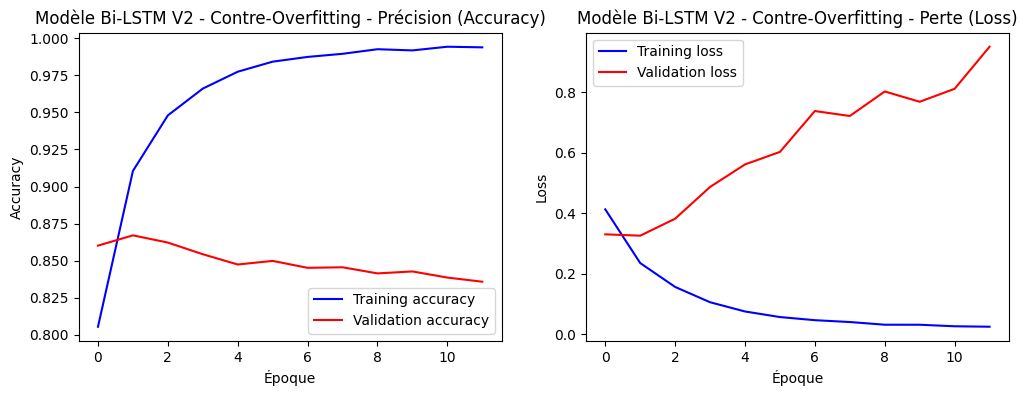


Évaluation finale du Modèle Bi-LSTM V2 sur l'ensemble de test:
Perte (Loss) : 0.3254
Précision (Accuracy) : 0.8671


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

# --- Hyperparamètres Réduits et Optimisés ---
vocab_size = 10000
max_length = 100
# Réduction de la capacité
embedding_dim = 64
lstm_units = 32

# --- 1. Construction du Modèle avec Recurrent Dropout et L2 ---
model_v2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # LSTM Bidirectionnel :
    #   - recurrent_dropout régularise les connexions récurrentes.
    #   - kernel_regularizer pour les poids d'entrée.
    Bidirectional(LSTM(
        lstm_units,
        recurrent_dropout=0.2, # Nouveau Dropout sur les connexions internes
        kernel_regularizer=regularizers.l2(1e-4)
    )),

    # Dropout sur les sorties du LSTM
    Dropout(0.4), # Légèrement réduit si le recurrent_dropout est actif

    # Couche Dense cachée avec Régularisation L2
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),

    # Couche de sortie
    Dense(1, activation='sigmoid')
])

# --- 2. Compilation et Early Stopping ---
model_v2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Résumé du Modèle Bi-LSTM V2 (Capacité Réduite + Recurrent Dropout):")
model_v2.summary()

# Early Stopping (patience ajustée)
early_stop_v2 = EarlyStopping(
    monitor='val_loss',
    patience=10, # On donne un peu plus de temps pour l'apprentissage plus lent
    restore_best_weights=True,
    verbose=1
)

# --- 3. Entraînement ---
num_epochs = 50
print(f"Début de l'entraînement du Modèle V2...")

history_v2 = model_v2.fit(
    train_padded, y_train,
    epochs=num_epochs,
    validation_data=(test_padded, y_test),
    callbacks=[early_stop_v2],
    verbose=1
)

# --- 4. Tracé et Évaluation finale ---
def plot_history(history, title):
    """Fonction utilitaire pour tracer la perte et la précision."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'{title} - Précision (Accuracy)')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Perte (Loss)')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_v2, 'Modèle Bi-LSTM V2 - Contre-Overfitting')

loss, accuracy = model_v2.evaluate(test_padded, y_test, verbose=0)
print(f"\nÉvaluation finale du Modèle Bi-LSTM V2 sur l'ensemble de test:")
print(f"Perte (Loss) : {loss:.4f}")
print(f"Précision (Accuracy) : {accuracy:.4f}")

### Modèle 7 : V2 - Approche équilibrée

**Stratégie** : Au lieu d'augmenter la régularisation, on **réduit la capacité** du modèle

**Changements** :
- `embedding_dim` : 100 → 64 (embeddings moins riches)
- `lstm_units` : 64 → 32 (moins de paramètres à apprendre)
- **Recurrent Dropout** : Nouveau type de dropout sur les connexions LSTM internes
  - Régularise les connexions récurrentes entre timesteps
  - Plus efficace que le dropout classique pour les RNN

**Philosophie** :
- Modèle plus simple = moins d'overfitting naturel
- Régularisation ciblée (recurrent_dropout)
- `patience=10` : Plus de tolérance pour l'apprentissage plus lent

**Trade-off** : Capacité ↓ mais généralisation ↑

# Préparation du Test sur nouvelles phrases

In [ ]:
# Nouvelles phrases à tester
new_sentences = [
    # Exemple Non-Sarcasme (Label attendu : 0)
    "I am truly excited to start this new job next week.",

    # Exemple Sarcasme (Label attendu : 1)
    "Oh, I just *love* having 50 new emails in my inbox on a Friday afternoon.",

    # Autre Non-Sarcasme
    "The weather here in Fes is quite pleasant today.",

    # Autre Sarcasme
    "I'm so glad my phone battery died right before my alarm went off. Perfect start to the day!",
]

# Le tokenizer doit être le MÊME que celui entraîné dans la Cellule 3
# (Assurez-vous que l'objet 'tokenizer' existe dans votre environnement)
# Si vous avez redémarré votre notebook, vous devrez ré-exécuter la Cellule 3.

# 1. Tokenization des nouvelles phrases
test_sequences = tokenizer.texts_to_sequences(new_sentences)

# 2. Padding (Doit utiliser les MÊMES paramètres: max_length=100, padding='post')
max_length = 100
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Nouvelles séquences paddées prêtes pour la prédiction (forme : {test_padded.shape})")

Nouvelles séquences paddées prêtes pour la prédiction (forme : (4, 100))


### Test sur phrases réelles

**Pipeline de prédiction** :
1. Tokenization avec le **même tokenizer** utilisé pour l'entraînement
2. Padding avec les **mêmes paramètres** (max_length=100, padding='post')
3. Prédiction avec le modèle entraîné

**⚠️ Point critique** : Le tokenizer doit être identique ! Sinon les indices ne correspondent plus.

**Phrases de test** :
- Non-sarcasmes : Phrases neutres/positives
- Sarcasmes : Ironie, exagération, contraste entre forme et fond

# Prédiction et Affichage

In [ ]:
import numpy as np
# Assurez-vous que 'model_v2' est le modèle entraîné le plus récent
predictions = model_v2.predict(test_padded)

print("\n--- Résultats de la Prédiction ---")

for sentence, proba in zip(new_sentences, predictions):
    # La prédiction est une probabilité (entre 0 et 1)
    # Nous utilisons un seuil de 0.5 pour la classification binaire
    is_sarcastic = 'SARCASE' if proba[0] >= 0.5 else 'NON-SARCASE'

    # Affichage du résultat
    print("---------------------------------")
    print(f"Phrase: {sentence}")
    print(f"Probabilité (Sarcasme): {proba[0]:.4f}")
    print(f"Classification: {is_sarcastic}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step

--- Résultats de la Prédiction ---
---------------------------------
Phrase: I am truly excited to start this new job next week.
Probabilité (Sarcasme): 0.9520
Classification: SARCASE
---------------------------------
Phrase: Oh, I just *love* having 50 new emails in my inbox on a Friday afternoon.
Probabilité (Sarcasme): 0.0151
Classification: NON-SARCASE
---------------------------------
Phrase: The weather here in Fes is quite pleasant today.
Probabilité (Sarcasme): 0.0167
Classification: NON-SARCASE
---------------------------------
Phrase: I'm so glad my phone battery died right before my alarm went off. Perfect start to the day!
Probabilité (Sarcasme): 0.1851
Classification: NON-SARCASE


### Interprétation des résultats

**Seuil de classification** : 0.5
- Probabilité ≥ 0.5 → SARCASME
- Probabilité < 0.5 → NON-SARCASME

**Analyse de la confiance** :
- Proba proche de 0 ou 1 : Modèle très confiant
- Proba proche de 0.5 : Modèle hésitant (phrase ambiguë)

**Cas intéressants** :
- Sarcasmes détectés avec haute confiance → Modèle comprend l'ironie
- Erreurs → Révèlent les limites (sarcasme subtil, contexte manquant)

## Synthèse et Conclusions

### Progression des architectures

| Modèle | Architecture | Accuracy typique | Forces | Limites |
|--------|--------------|------------------|--------|---------|
| **Simple** | Dense sans embedding | ~65-70% | Baseline rapide | Aucune sémantique |
| **Embedding** | Embedding + GAP | ~75-80% | Représentations sémantiques | Ignore l'ordre |
| **+ Régularisation** | + Dropout + Early Stop | ~78-82% | Généralisation | Encore ordre ignoré |
| **LSTM** | LSTM unidirectionnel | ~80-85% | Capture l'ordre | Contexte unidirectionnel |
| **Bi-LSTM** | LSTM bidirectionnel | ~85-88% | Contexte complet | Risque d'overfitting |
| **Bi-LSTM Régularisé** | + L2 + Dropout | ~84-87% | Robuste | Training plus lent |
| **Bi-LSTM V2** | Capacité réduite | ~83-86% | Équilibré | Moins de capacité |

### Leçons clés du NLP

**1. Prétraitement est critique**
- Tokenization uniforme (même vocabulaire train/test)
- Padding cohérent (même max_length)
- Gestion des mots inconnus (OOV token)

**2. Embeddings > Indices bruts**
- Apprennent des représentations sémantiques
- Similarité cosinus entre mots similaires
- Transférables (Word2Vec, GloVe, BERT)

**3. Ordre des mots compte**
- Sarcasme nécessite contexte séquentiel
- LSTM > GlobalAveragePooling pour tâches séquentielles
- Bi-LSTM encore mieux pour nuances linguistiques

**4. Régularisation adaptée au problème**
- Dropout classique : Entre couches
- Recurrent Dropout : Connexions LSTM
- L2 : Poids du réseau
- Early Stopping : Éviter overtraining
- Réduire capacité : Alternative à sur-régulariser

### Améliorations possibles

**1. Architectures plus avancées**
- **Attention mechanisms** : Focus sur mots clés du sarcasme
- **Transformers** (BERT, GPT) : Contexte bidirectionnel massivement parallèle
- **Multi-head attention** : Différents aspects sémantiques

**2. Données et features**
- **Data augmentation** : Paraphrases, back-translation
- **Features contextuelles** : Émojis, ponctuation (!!!, ...), majuscules
- **Contexte étendu** : Article complet vs juste titre

**3. Embeddings pré-entraînés**
- **Word2Vec / GloVe** : Embeddings généraux sur large corpus
- **BERT embeddings** : Contextuels (même mot, différents sens)
- **Fine-tuning** : Adapter BERT sur dataset sarcasme

**4. Techniques ensemblistes**
- Combiner LSTM + CNN
- Moyenne de plusieurs modèles
- Stacking de prédictions

### Cas d'usage réels

**Applications** :
- 📱 Modération de contenus sur réseaux sociaux
- 🛒 Analyse de sentiments e-commerce (détecter fausses critiques positives)
- 💬 Chatbots (comprendre intentions réelles)
- 📊 Analyse d'opinions politiques

**Défis persistants** :
- Sarcasme culturel (varie selon langue/région)
- Contexte externe nécessaire ("Finally!" → sarcasme sans le contexte)
- Ambiguïté inhérente (même pour humains)

### Recommandation finale

Pour ce problème :
- **Production** : Bi-LSTM V2 (équilibre performance/robustesse)
- **Recherche** : Bi-LSTM régularisé (optimiser hyperparamètres)
- **État de l'art** : Fine-tuner BERT sur le dataset

**Accuracy cible réaliste** : 85-90% (au-delà, nécessite modèles sophistiqués + données augmentées)

Ce notebook a couvert le parcours complet du NLP : du prétraitement basique aux architectures récurrentes bidirectionnelles, avec gestion pratique de l'overfitting. 🎯